## CNN

In [1]:
def cnn_model_fn(features, labels, mode):
    """Model function for CNN."""
    # Input Layer
    # Reshape X to 4-D tensor: [batch_size, width, height, channels]
    # Angio images are 23x23 pixels, and have one color channel
    input_layer = tf.reshape(features["x"], [-1, 23, 23, 1])
    print('input_layer: ', input_layer.shape)
    
    # Convolutional Layer #1
    # Computes 32 features using a 5x5 filter with ReLU activation.
    # Padding is added to preserve width and height.
    # Input Tensor Shape: [batch_size, 23, 23, 1]
    # Output Tensor Shape: [batch_size, 23, 23, 32]
    conv1 = tf.layers.conv2d(
        inputs=input_layer,
        filters=32,
        kernel_size=[5, 5],
        padding="same",
        activation=tf.nn.relu)
    print('conv1: ', conv1.shape)

    # Pooling Layer #1
    # First max pooling layer with a 2x2 filter and stride of 2
    # Input Tensor Shape: [batch_size, 23, 23, 32]
    # Output Tensor Shape: [batch_size, 11, 11, 32]
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)
    print('pool1: ', pool1.shape)

  # Convolutional Layer #2
  # Computes 64 features using a 5x5 filter.
  # Padding is added to preserve width and height.
  # Input Tensor Shape: [batch_size, 11, 11, 32]
  # Output Tensor Shape: [batch_size, 11, 11, 64]
    conv2 = tf.layers.conv2d(
        inputs=pool1,
        filters=64,
        kernel_size=[5, 5],
        padding="same",
        activation=tf.nn.relu)
    print('conv2: ', conv2.shape)

  # Pooling Layer #2
  # Second max pooling layer with a 2x2 filter and stride of 2
  # Input Tensor Shape: [batch_size, 11, 11, 64]
  # Output Tensor Shape: [batch_size, 5, 5, 64]
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)
    print('pool2: ', pool2.shape)

  # Flatten tensor into a batch of vectors
  # Input Tensor Shape: [batch_size, 5, 5, 64]
  # Output Tensor Shape: [batch_size, 5 * 5 * 64]
    pool2_flat = tf.reshape(pool2, [-1, 5 * 5 * 64])
    print('pool2_flat: ', pool2_flat.shape)

  # Dense Layer
  # Densely connected layer with 1024 neurons
  # Input Tensor Shape: [batch_size, 5 * 5 * 64]
  # Output Tensor Shape: [batch_size, 1024]
    dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)
    print('dense: ', dense.shape)

  # Add dropout operation; 0.6 probability that element will be kept
    dropout = tf.layers.dropout(
        inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)
    print('dropout: ', dropout.shape)

  # Logits layer
  # Input Tensor Shape: [batch_size, 1024]
  # Output Tensor Shape: [batch_size, 2]
    logits = tf.layers.dense(inputs=dropout, units=2)
    print('logits: ', logits.shape)
    
    classes = tf.argmax(input = logits, axis = 1, name = "class")
    print('classes: ', classes.shape)
    probabilities = tf.nn.softmax(logits, name = "softmax_tensor")
    print('probabilities: ', probabilities.shape)
    
    predictions = {
        # Generate predictions (for PREDICT and EVAL mode)
        "classes": classes,
        # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
        # `logging_hook`
        "probabilities": probabilities
    }
    print('predictions: ', len(predictions))

    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

  # Calculate Loss (for both TRAIN and EVAL modes)
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)
    print('...Loss...')
  # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

  # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {
        "accuracy": tf.metrics.accuracy(
            labels = labels, predictions = predictions["classes"]),
        "precision": tf.metrics.precision(
            labels = labels, predictions = predictions["classes"]),
        "recall": tf.metrics.recall(
            labels = labels, predictions = predictions["classes"]),
        "ROC": tf.metrics.auc(
            labels = labels, predictions = predictions["classes"])}
    return tf.estimator.EstimatorSpec(
        mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)    

## Train the model

In [2]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Load training and eval data
mnist = tf.contrib.learn.datasets.load_dataset("mnist")
train_data = mnist.train.images  # Returns np.array
train_labels = np.asarray(mnist.train.labels, dtype=np.int32)
eval_data = mnist.test.images  # Returns np.array
eval_labels = np.asarray(mnist.test.labels, dtype=np.int32)

count =  883402
--- 4.464690923690796 seconds ---
labels shape:  (883402, 1)
originals shape:  (883402, 23, 23)


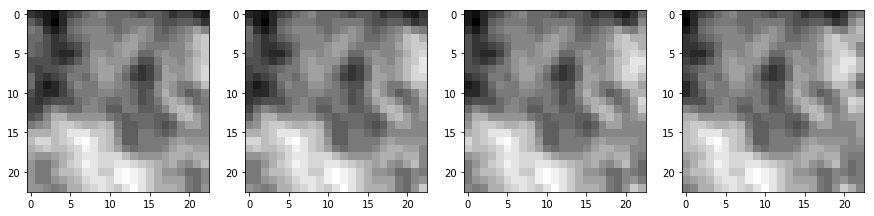

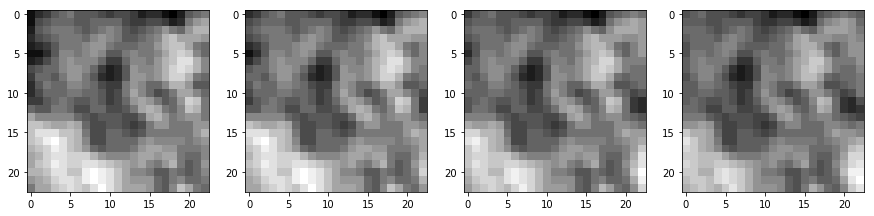

[150. 151. 150. 148. 149. 151. 154. 155.]


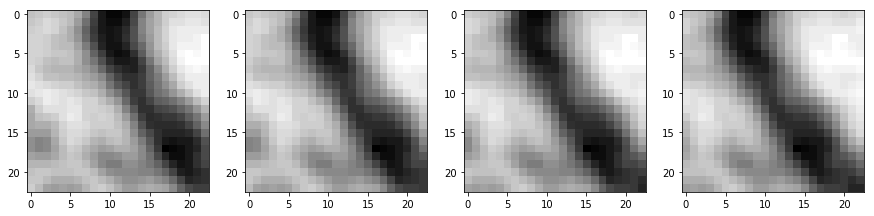

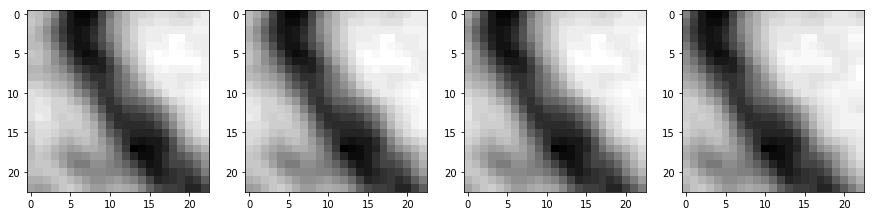

[154. 147. 140. 138. 141. 145. 146. 148.]


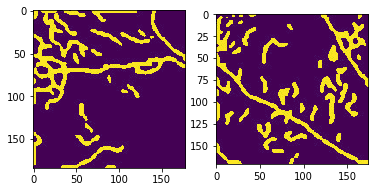

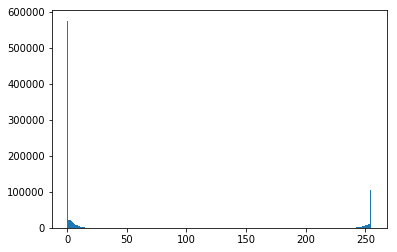

(883402, 1)
[[0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]]


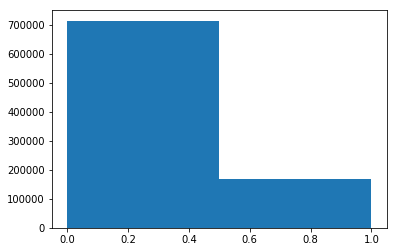

Number of negative samples:  713956
Number of positive samples:  169446
Fraction of positive samples:  19.181074980586416 %
Need to randomly choose  169446  negative samples to make it 1 : 1
338892 169446 169446
train:  271114 , test:  67778
Positive. y_train:  135557 , y_test:  33889
Negative. y_train:  135557 , y_test:  33889
(271114, 23, 23) (271114, 1)
(67778, 23, 23) (67778, 1)
Training set has mean 152.21744 and s.d. 31.489965
Standardized training set has mean 1.4794105e-05 and s.d. 0.999999
Test set has mean 152.28171 and s.d. 31.518911
Standardized training set has mean 0.002041808 and s.d. 1.0009185
(100, 23, 23) (100, 1)
43


In [3]:
# Load angio data
%run angio_data.ipynb

In [4]:
# Create the Estimator
mnist_classifier = tf.estimator.Estimator(
    model_fn=cnn_model_fn, model_dir="/tmp/angio_model5")

# Set up logging for predictions
# Log the values in the "Softmax" tensor with label "probabilities"
tensors_to_log = {"probabilities": "softmax_tensor"}
logging_hook = tf.train.LoggingTensorHook(
    tensors=tensors_to_log, every_n_iter=3000)

# Train the model
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": X_train_std},
    y=y_train,
    #x={"x": train_data},
    #y=train_labels,
    batch_size=100,
    num_epochs=None,
    shuffle=True)
mnist_classifier.train(
    input_fn=train_input_fn,
    steps=12000,
    hooks=[logging_hook])

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/angio_model5', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x18892b1358>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
input_layer:  (100, 23, 23, 1)
conv1:  (100, 23, 23, 32)
pool1:  (100, 11, 11, 32)
conv2:  (100, 11, 11, 64)
pool2:  (100, 5, 5, 64)
pool2_flat:  (100, 1600)
dense:  (100, 1024)
dropout:  (100, 1024)
logits:  (100, 2)
classes:  (100,)
probabilities:  (100, 2)
predictions:  2
...Loss...
INFO:tensorflow:Done calling model_fn.
INFO:ten

INFO:tensorflow:loss = 0.6633745, step = 3001 (13.878 sec)
INFO:tensorflow:global_step/sec: 8.0704
INFO:tensorflow:loss = 0.67580754, step = 3101 (12.383 sec)
INFO:tensorflow:global_step/sec: 8.11589
INFO:tensorflow:loss = 0.6676161, step = 3201 (12.323 sec)
INFO:tensorflow:global_step/sec: 9.23397
INFO:tensorflow:loss = 0.6723104, step = 3301 (10.828 sec)
INFO:tensorflow:global_step/sec: 9.62137
INFO:tensorflow:loss = 0.670116, step = 3401 (10.394 sec)
INFO:tensorflow:global_step/sec: 9.77726
INFO:tensorflow:loss = 0.6474243, step = 3501 (10.228 sec)
INFO:tensorflow:global_step/sec: 9.16751
INFO:tensorflow:loss = 0.6680367, step = 3601 (10.908 sec)
INFO:tensorflow:global_step/sec: 7.89402
INFO:tensorflow:loss = 0.68272537, step = 3701 (12.668 sec)
INFO:tensorflow:global_step/sec: 7.29783
INFO:tensorflow:loss = 0.6737725, step = 3801 (13.703 sec)
INFO:tensorflow:global_step/sec: 8.76147
INFO:tensorflow:loss = 0.658252, step = 3901 (11.414 sec)
INFO:tensorflow:global_step/sec: 8.78236
I

INFO:tensorflow:global_step/sec: 8.14945
INFO:tensorflow:loss = 0.6380006, step = 8601 (12.272 sec)
INFO:tensorflow:global_step/sec: 7.27137
INFO:tensorflow:loss = 0.6162972, step = 8701 (13.756 sec)
INFO:tensorflow:global_step/sec: 8.91748
INFO:tensorflow:loss = 0.6263196, step = 8801 (11.212 sec)
INFO:tensorflow:global_step/sec: 8.56981
INFO:tensorflow:loss = 0.5884374, step = 8901 (11.669 sec)
INFO:tensorflow:global_step/sec: 8.37548
INFO:tensorflow:probabilities = [[0.66614825 0.33385172]
 [0.10409522 0.8959048 ]
 [0.8597502  0.14024974]
 [0.46841344 0.5315865 ]
 [0.68594784 0.31405213]
 [0.7644501  0.23554991]
 [0.6663047  0.33369538]
 [0.4310613  0.5689387 ]
 [0.75906175 0.24093822]
 [0.62407064 0.37592933]
 [0.6953288  0.3046713 ]
 [0.6823262  0.31767383]
 [0.47569948 0.52430046]
 [0.7392719  0.26072815]
 [0.54665357 0.4533464 ]
 [0.89633554 0.10366451]
 [0.7318486  0.26815143]
 [0.62036484 0.3796352 ]
 [0.44294134 0.5570587 ]
 [0.29216596 0.70783406]
 [0.46548858 0.53451145]
 [

In [5]:
# Evaluate the model and print results
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": X_test_std},
    y=y_test,
    #x={"x": eval_data},
    #y=eval_labels,
    num_epochs=1,
    shuffle=False)
eval_results = mnist_classifier.evaluate(input_fn=eval_input_fn)
print(eval_results)

INFO:tensorflow:Calling model_fn.
input_layer:  (?, 23, 23, 1)
conv1:  (?, 23, 23, 32)
pool1:  (?, 11, 11, 32)
conv2:  (?, 11, 11, 64)
pool2:  (?, 5, 5, 64)
pool2_flat:  (?, 1600)
dense:  (?, 1024)
dropout:  (?, 1024)
logits:  (?, 2)
classes:  (?,)
probabilities:  (?, 2)
predictions:  2
...Loss...
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-05-22-21:03:11
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/angio_model5/model.ckpt-12000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-05-22-21:03:35
INFO:tensorflow:Saving dict for global step 12000: ROC = 0.739355, accuracy = 0.73935497, global_step = 12000, loss = 0.5555196, precision = 0.7440356, recall = 0.7297648
{'ROC': 0.739355, 'accuracy': 0.73935497, 'loss': 0.5555196, 'precision': 0.7440356, 'recall': 0.7297648, 'global_step': 12000}


In [ ]:
tf.metrics.auc(y_train, predictions)